# Sentiment Text Classification Through GoogleNews Word2Vec & CNN

Ian Steenstra, Rensselaer Polytechnic Institute, Dec 14th, 2019 

## Introduction 

Sentiment classification in text is a growing field of research because of its potential use in today's vast amount of text-based data online. The reason for building this model is to create a baseline model for sentiment classification in a therapeutic instant messenger. It is hard to find enough data to train on conversations because of privacy reasons, but I was able to find a trustworthy dataset (ISEAR) where they asked participants from different cultural backgrounds to classify an emotion to a phrase [4]. Through the use of a multi-layered Convolutional Neural Network (CNN), my model is relevant to the overall field of Deep Learning. The hard problem with sentiment analysis is that it is not always consistent between people. You can probably remember many times when you misunderstood the emotional backing of a statement. I hope my model provides a step in the right direction of having a device to help people understand each other better in a time of mostly text-based communication. 

## Background

Most of the models today all use a form of a CNN to retrieve the parameters that will be able to classify sentiment in text. However, there are different ways of going about it and with added data manipulation. One technique is through a very deep network with individual characters of text as the input, as much as 29 convolutional layers; which, results in very low classification error, but lower accuracy scores [2]. Others use a CNN off of the individual words themselves and train on the sentiment classification. I, however, used a different approach that has been widely found to be one of the best. My model first uses word embeddings to convert the phrases into vectors of features at the word level. After, they are fed into a CNN where I train on the ISEAR dataset. I use a very large WordNet model that allows me to extract features for the vector representation of the words. The WordNet I use is from Google News and positions words similar to each other closer together [3]. This allows a model to easily find importance by using the distance of words to each other. The features for each word provides a powerful tool to learn from using a CNN. 

## Data

The data that I train my model on is the ISEAR dataset which has 7515 pairs of datapoints each containing a sentiment and phrase. There are 7 different sentiments: joy, fear, anger, sadness, disgust, shame and guilt. I make each a key in a dictionary to help with one-hot-encoding so I can easily train multiple categories on a CNN. Before I train on the data, I first need to convert each statement into a vector of features/parameters. I do this by using a word to vector model. I use the genism library to extract a model that I can use provided by the GoogleNews Word2Vec model; which it has 300-dimensional vectors for 3 million words and phrases [3]. This is a powerful tool in extracting features to learn from because it captures many linguistic regularities [3]. Below shows two examples of the distance of a word to others in space through a simple visualization. Before I can even use this model on the sentences, I need to do some data preprocessing. In this step, I need to turn each phrase into tokens; which are just the important parts of the phrase. This means I need to remove all the punctuation, extra spaces, and stop words. Stop words are words that appear most often in English and are found to be not that important linguistically. Also, using lemmatization is helpful as well. An example of lemmatization is using the word, play, instead of playing, played, and plays. It converts each word into its smallest root. The tokens for a phra then convert into a 300-dimensional vector through the use of the Word2Vec model. This is done by finding the 300-dimensional vector for each token and averaging each dimension between all the tokens. Averaging is needed to make sure the input space is the same for every phrase because not every phrase has the same length. 

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

nltk.download('wordnet')

C:\Users\steeni\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\steeni\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\steeni\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\steeni\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\frame

True

In [2]:
dataset = pd.read_csv('ISEAR.csv').iloc[:, :-1]
dataset.isnull().sum()

Sentiment    0
Sentence     0
dtype: int64

In [3]:
dataset.head()

,Sentiment,Sentence
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [4]:
emotion_labels = {'joy': 0, 'fear': 1, 'anger': 2, 'sadness': 3, 'disgust': 4, 'shame': 5, 'guilt': 6}

#### Below extracts the GoogleNews word2vec model which is stored as a binary file. 

In [5]:
emb_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

#### Below is the function that graphs some of the closest words to that of the inputted word. 

In [6]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)
    
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

#### Below displays the words and phrases that are close in distance to the word promotion. 

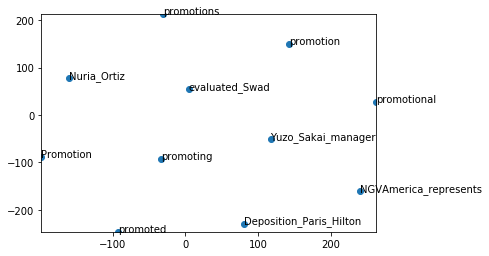

In [7]:
display_closestwords_tsnescatterplot(emb_model, 'promotion')

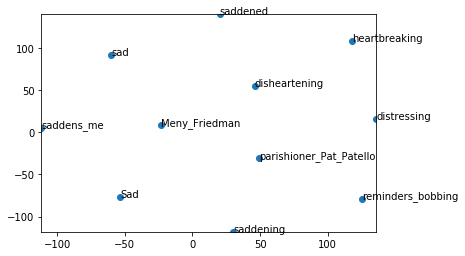

In [8]:
display_closestwords_tsnescatterplot(emb_model, 'sad')

In [9]:
def phrase_pre_processing(phrase):
    # Basic Text PreProcessing
    phrase = re.sub(' +', ' ', re.sub(r'\d+', '', phrase.lower()).translate(str.maketrans("","", string.punctuation+'\n'+'\r'+'\t')))
    
    # Tokenizing
    tokens = word_tokenize(phrase)
    
    # Remove Stop Words
    stop_words = set(stopwords.words('english'))
    tokens = [i for i in tokens if not i in stop_words]
    
    # Lemmatization
    lemmatizer=WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(i) for i in tokens]

    return tokens

In [10]:
def phrase_to_embedding(tokens):
    words = [word for word in tokens if word in emb_model.vocab]
    embeddings = np.zeros(300)
    if len(words) >= 1:  
        avg = np.mean(emb_model[words], axis=0)
        for idx, e in enumerate(avg):
            embeddings.flat[idx] = e
            
    return embeddings

#### Below is an example of the features in a vector embedding of a sentence. 

In [11]:
test_sentence = "I finally got a promotion!"
tokens = phrase_pre_processing(test_sentence)
phrase_to_embedding(tokens)

array([-0.00919596,  0.04130046, -0.17041016,  0.02815755,  0.08520508,
       -0.13476562, -0.01555379, -0.15600586, -0.09468587,  0.12760417,
       -0.01936849, -0.19108073, -0.08898926, -0.05269368, -0.05875651,
       -0.01236979,  0.20426433,  0.12109375,  0.10009766,  0.0382487 ,
       -0.07063802,  0.08528646,  0.12223307, -0.08333334,  0.14241536,
        0.02026367,  0.0181071 ,  0.09338379,  0.17545573,  0.17382812,
       -0.10347494, -0.02410889, -0.03238932,  0.05224609,  0.0970459 ,
        0.06062825,  0.11604818, -0.01233419,  0.13423665, -0.04842122,
       -0.01855469, -0.21647136,  0.15022786, -0.01318359, -0.03934733,
       -0.07926432,  0.02058919, -0.02400716,  0.02001953,  0.07027181,
       -0.0226237 ,  0.17220052, -0.01303101,  0.07519531, -0.02614339,
        0.03597005, -0.01717122, -0.07698568,  0.0135905 , -0.16113281,
       -0.01281738,  0.13964844, -0.08276367, -0.03173828, -0.1570638 ,
       -0.04212443,  0.01627604, -0.01501465,  0.00146484,  0.14

#### Below goes through each datapoint from the ISEAR dataset to convert each phrase to its 300-dimensional vector of features and the sentiment to a one-hot-encoding representation.  

In [12]:
X = []
y = []

for index, row in dataset.iterrows():
    tokens = phrase_pre_processing(row['Sentence'])
    embeddings = phrase_to_embedding(tokens)
    one_hot = np.zeros(7)
    one_hot.flat[emotion_labels[row['Sentiment']]] = 1
    y.append(one_hot)
    X.append(embeddings)

X = np.array(X)    
y = np.array(y)

#### I split the data into a training set, validation set, and a test set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6012, 300), (1504, 300), (6012, 7), (1504, 7))

In [14]:
train_X,valid_X,train_label,valid_label = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((4809, 300), (1203, 300), (4809, 7), (1203, 7))

## Model

I use a multi-layered CNN from the TensorFlow library to find hyperparameters that will be able to help in classifying a phrase to its correlated sentiment. My model uses three dense layers, where the last layer has a dimension of 7 which is used to distinguish which sentiment out of the 7 total has the highest value. The validation set is used to tweak the hyperparameters on each epoch during the training phase. I use binary cross entropy as my loss function, the Adam algorithm as my optimizer and accuracy as my training metric. The activation function on each layer is the rectified linear unit or ReLU, except for the last layer which uses a sigmoid activation function. During training, I use a batch size of 64 and 20 epochs. I find that a higher epoch, such as 100, results in a worse performance. This could because of overfitting to the training data. After the model finishes training, the accuracy on the test set is 0.89 and a loss of 0.29. Lastly, the number of trainable parameters finds to be 28,487. 

In [15]:
input_dim = X_train.shape[1]  # Number of features
batch_size = 64
epochs = 20

In [16]:
model = Sequential()
model.add(layers.Dense(64, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7, activation='sigmoid'))

In [17]:
model.compile(loss=binary_crossentropy, optimizer=Adam(), metrics=['accuracy'])

In [18]:
model_train = model.fit(train_X, train_label, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_label))

Train on 4809 samples, validate on 1203 samples
Epoch 1/20
4809/4809 [==============================] - 1s 278us/sample - loss: 0.4521 - accuracy: 0.8511 - val_loss: 0.3977 - val_accuracy: 0.8571
Epoch 2/20
4809/4809 [==============================] - 0s 68us/sample - loss: 0.3766 - accuracy: 0.8588 - val_loss: 0.3499 - val_accuracy: 0.8640
Epoch 3/20
4809/4809 [==============================] - 0s 68us/sample - loss: 0.3318 - accuracy: 0.8709 - val_loss: 0.3156 - val_accuracy: 0.8755
Epoch 4/20
4809/4809 [==============================] - 0s 72us/sample - loss: 0.3084 - accuracy: 0.8786 - val_loss: 0.2994 - val_accuracy: 0.8791
Epoch 5/20
4809/4809 [==============================] - 0s 91us/sample - loss: 0.2941 - accuracy: 0.8838 - val_loss: 0.2905 - val_accuracy: 0.8833
Epoch 6/20
4809/4809 [==============================] - 0s 82us/sample - loss: 0.2841 - accuracy: 0.8870 - val_loss: 0.2867 - val_accuracy: 0.8878
Epoch 7/20
4809/4809 [==============================] - 0s 73us/sampl

In [19]:
test_eval = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', test_eval[0])
print('Test Accuracy:', test_eval[1])

Test Loss: 0.2937986603442659
Test Accuracy: 0.8905776


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 28,487
Trainable params: 28,487
Non-trainable params: 0
_________________________________________________________________


## Results

The test results show that my model did learn how to classify sentiment from text pretty well. From the graphs below, you can see at around 6 epochs is where both the training accuracy and loss branch away from the validation accuracy and loss. This is most likely because the model is overfitting to the data. However, I use the validation set to combat this issue. Comparably to other models, this separation is not that bad. The results from my model beat many comparable sentiment classification models. For instance, a model using only the words of the phrase as the input to a CNN results in an accuracy score of only 0.6675 [5]. Another model uses a uniform unigram feature extraction with a naive abyes classifier, but only results in an average accuracy of around 0.77 [1]. All compared models were trained on the ISEAR dataset as well. I believe the great accuracy scores of my model come from the Word2Vec model for word embeddings. The most important part of machine learning is using the right features. Through my results and comparing them to others, leads me to say that using a powerful Word2Vec model is the best way to do text classification. 

In [21]:
accuracy = model_train.history['accuracy']
val_accuracy = model_train.history['val_accuracy']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))

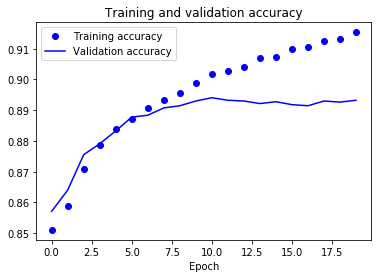

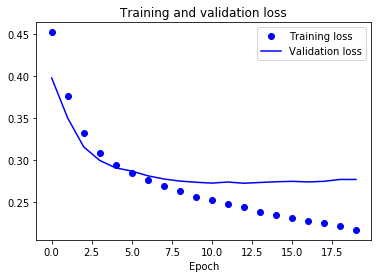

In [22]:
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.xlabel("Epoch")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel("Epoch")
plt.title('Training and validation loss')
plt.legend();

#### Below is used to test out phrase sentiment classification. Feel free to try it out!

In [23]:
test_phrase = "I finally got a promotion!"
tokens = phrase_pre_processing(test_phrase)
embeddings = phrase_to_embedding(tokens)
idx = model.predict(embeddings.reshape(-1,300)).argmax()
for key, val in emotion_labels.items():
    if val == idx:
        print("Sentiment Detector: ", key)

Sentiment Detector:  joy


## Problems & Future Work

Most of the problems I encountered were during the word embeddings retrieval. At first, I did not know how to get each phrase to have the same dimensional space. Until I did some research and found that taking the average across each word leads to good results. Another problem was how to correctly tokenize the phrases so that the Word2Vec model would be able to get the word embeddings of each word. Even though I did some data preprocessing, some tokens or words were not found within the Word2Vec model. My solution was to simply skip that word and it would not add to the overall average. An issue could occur if the phase returns only one token and that token is not within the model. For future work, I would train the Word2Vec model on all the tokens within the dataset so that it could capture every token. Also, I would look into another way that I can keep the input space the same dimension without losing some of the information lost when averaging the tokens. This is because some tokens might be more important than others and their feature values should weigh more than other tokens in the same phrase. Lastly, I would try different models other than a CNN to train on the word embeddings retrieved from the ISEAR dataset, such as an LSTM or Naive Bayes. 

## References

[1] Bincy Thomas, Vinod P, Dhanya K A, (2014) Multiclass Emotion Extraction from Sentences. International Journal of Scientific & Engineering Research, https://pdfs.semanticscholar.org/54ed/f53161d1e9811e33b40c2bb26792583dd126.pdf. 

[2] Brownlee, Jason. “Best Practices for Text Classification with Deep Learning.” Machine Learning Mastery, 7 Aug. 2019, machinelearningmastery.com/best-practices-document-classification-deep-learning/.

[3] “Google Code Archive - Long-Term Storage for Google Code Project Hosting.” Google, Google, 29 July 2013, code.google.com/archive/p/word2vec/.

[4] Scherer, K.R. and Wallbotth, G. (1994) Evidence for Universality and Cultural Var-iation of  Differential Emotion Response Patterning. Journal of Personality and So-cial Psychology, 66, 310-328. https://doi.org/10.1037/0022-3514.66.2.310  

[5] Yuxiang Zhang and Jiamei Fu and Dongyu She and Ying Zhang and Senzhang Wang and Jufeng Yang. (2018) Text Emotion Distribution Learning via Multi-Task Convolutional Neural Network. International Joint Conferences on Artificial Intelligence Organization, https://www.ijcai.org/proceedings/2018/0639.pdf.